# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Lab 5: Regularization and Model Selection

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai<br/>
**Lab Team**: Marios Mattheakis, Hayden Joy, Chris Gumb, and Eleni Kaxiras<br/>
**Authors**: Hayden Joy, Marios Mattheakis, Abhimanyu Vasishth
<hr style='height:2px'>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
# styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
# HTML(styles)
from IPython.display import Image

For this section, our goal is to get you familiarized with Regularization in Multiple Linear Regression and to start thinking about Model and Hyper-Parameter Selection. 

Specifically, we will:

- Load in the King County House Price Dataset
- Perform some basic EDA
- Split the data up into a training, **validation**, and test set
- Scale the variables (by standardizing or normalizing them) and seeing why we need to do this
- Learn what **regularization** is and how it can help
- Understand **ridge** and **lasso** regression
- Get an introduction to **cross-validation** using RidgeCV and LassoCV

<img src="fig/meme.png" width="400">

In [2]:
# Data and Stats packages
import numpy as np
import pandas as pd
pd.set_option('max_columns', 200)

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#from prettytable import PrettyTable

# EDA: House Prices Data From Kaggle

For our dataset, we'll be using the house price dataset from [King County, WA](https://en.wikipedia.org/wiki/King_County,_Washington). The dataset is from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction). 

The task is to build a regression model to **predict the price**, based on different attributes. First, let's do some EDA.

In [3]:
# Load the dataset 
house_df = pd.read_csv('./data/kc_house_data.csv')
len(house_df)

21613

In [4]:
house_df = house_df.sample(frac=1, random_state=42)[0:4000]
print(house_df.shape)
print(house_df.dtypes)
house_df.head()

(4000, 21)
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
735,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
2830,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
4106,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
16218,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
19964,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


Now let's check for null values and look at the datatypes within the dataset.

In [5]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 735 to 3455
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             4000 non-null   int64  
 1   date           4000 non-null   object 
 2   price          4000 non-null   float64
 3   bedrooms       4000 non-null   int64  
 4   bathrooms      4000 non-null   float64
 5   sqft_living    4000 non-null   int64  
 6   sqft_lot       4000 non-null   int64  
 7   floors         4000 non-null   float64
 8   waterfront     4000 non-null   int64  
 9   view           4000 non-null   int64  
 10  condition      4000 non-null   int64  
 11  grade          4000 non-null   int64  
 12  sqft_above     4000 non-null   int64  
 13  sqft_basement  4000 non-null   int64  
 14  yr_built       4000 non-null   int64  
 15  yr_renovated   4000 non-null   int64  
 16  zipcode        4000 non-null   int64  
 17  lat            4000 non-null   float64
 18  long  

In [6]:
house_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,4.000000e+03,4.000000e+03,4000.000000,4000.000000,4000.000000,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.00000
mean,4.586542e+09,5.497522e+05,3.379250,2.116563,2096.645250,1.616511e+04,1.475000,0.007750,0.232500,3.420750,7.668250,1792.465000,304.18025,1970.564250,89.801500,98078.035500,47.560091,-122.214060,1997.75900,12790.67800
std,2.876700e+09,3.890505e+05,0.922568,0.783175,957.785141,5.120888e+04,0.530279,0.087703,0.768174,0.646393,1.194173,849.986192,455.26354,29.141872,413.760082,54.073374,0.139070,0.141879,701.60987,26085.20301
min,1.000102e+06,8.250000e+04,0.000000,0.000000,384.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,384.000000,0.00000,1900.000000,0.000000,98001.000000,47.155900,-122.515000,620.00000,659.00000
25%,2.126074e+09,3.249500e+05,3.000000,1.750000,1420.000000,5.200000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1180.000000,0.00000,1951.000000,0.000000,98033.000000,47.468175,-122.328000,1490.00000,5200.00000
50%,3.889350e+09,4.550000e+05,3.000000,2.250000,1920.000000,7.675000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1550.000000,0.00000,1974.500000,0.000000,98065.000000,47.573800,-122.231000,1840.00000,7628.00000
75%,7.334526e+09,6.541250e+05,4.000000,2.500000,2570.000000,1.087125e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2250.000000,590.00000,1995.000000,0.000000,98118.000000,47.679100,-122.127000,2370.00000,10240.00000
max,9.842300e+09,5.570000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.00000,2015.000000,2015.000000,98199.000000,47.777500,-121.315000,5790.00000,560617.00000


Let's choose a subset of columns here. **NOTE**: The way I'm selecting columns here is not principled and is just for convenience. In your homework assignments (and in real life), we expect you to choose columns more rigorously.

1. `bedrooms`
2. `bathrooms`
3. `sqft_living`
4. `sqft_lot`
5. `floors`
6. `sqft_above`
7. `sqft_basement`
8. `lat`
9. `long`
10. **`price`**: Our response variable

In [7]:
cols_of_interest = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement',
                    'lat', 'long', 'price']
house_df = house_df[cols_of_interest]

# Convert house price to 1000s of dollars
house_df['price'] = house_df['price']/1000

Let's see how the response variable (`price`) is distributed

Text(0.5, 0, 'price')

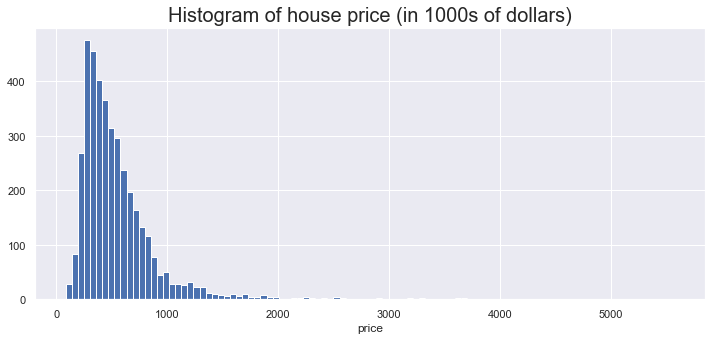

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(house_df['price'], bins=100)
ax.set_title('Histogram of house price (in 1000s of dollars)', fontsize = 20);
ax.set_xlabel("price")

Text(0.5, 0, 'price')

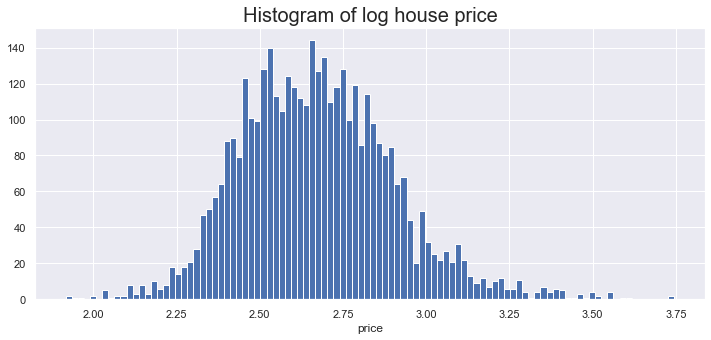

In [9]:
house_df['log_price'] = np.log10(house_df['price'])
house_df['log_price'].describe()

fig, ax = plt.subplots(figsize=(12,5))
ax.hist(house_df['log_price'], bins=100)
ax.set_title('Histogram of log house price', fontsize = 20);
ax.set_xlabel("price")

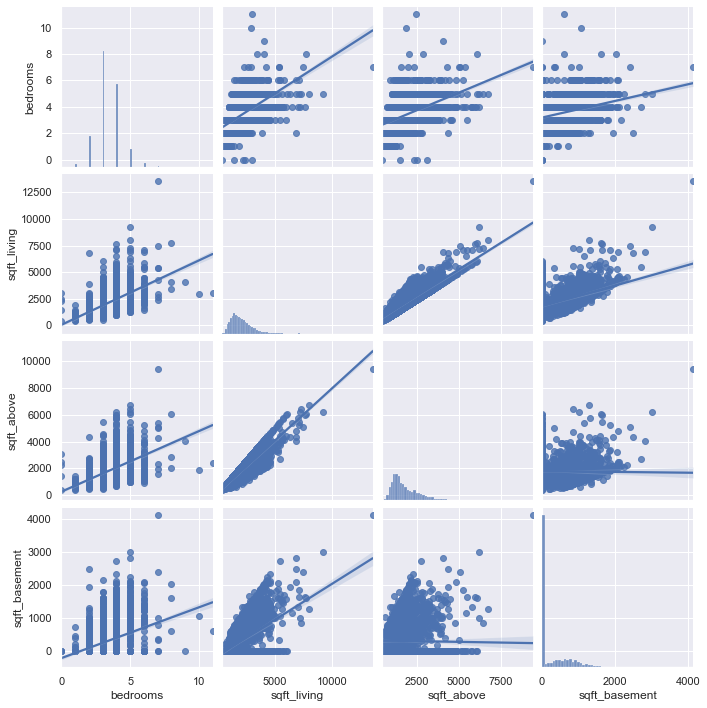

In [10]:
# This takes a bit of time but is worth it!!
sns.pairplot(house_df[['bedrooms', 'sqft_living', 'sqft_above', 'sqft_basement']], kind='reg', diag_kind='hist');

## Train-Validation-Test Split

Up until this point, we have only had a train-test split. Why are we introducing a validation set? What's the point?

This is the general idea: 

1. **Training Set**: Data you have seen. You train different types of models with various different hyper-parameters and regularization parameters on this data. 


2. **Validation Set**: Used to compare different models. We use this step to tune our hyper-parameters i.e. find the optimal set of hyper-parameters (such as $k$ for k-NN or our $\beta_i$ values or number of degrees of our polynomial for linear regression). Pick your best model here. 



3. **Test Set**: Using the best model from the previous step, simply report the score e.g. $R^2$ score, MSE or any metric that you care about, of that model on your test set. **DON'T TUNE YOUR PARAMETERS HERE!**. Why, I hear you ask? Because we want to know how our model might do on data it hasn't seen before. We don't have access to this data (because it may not exist yet) but the test set, which we haven't seen or touched so far, is a good way to mimic this new data. 

Let's do 60% train, 20% validation, 20% test for this dataset.

In [11]:
from sklearn.model_selection import train_test_split

# first split the data into a train-test split and don't touch the test set yet
train_val_df, test_df = train_test_split(house_df, test_size=0.2, random_state=42)

# next, split the training set into a train-validation split
# the test-size is 0.25 since we are splitting 80% of the data into 20% and 60% overall
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

print('Train Set: {0:0.2f}%'.format(100*train_df.size/house_df.size))
print('Validation Set: {0:0.2f}%'.format(100*val_df.size/house_df.size))
print('Test Set: {0:0.2f}%'.format(100*test_df.size/house_df.size))

Train Set: 60.00%
Validation Set: 20.00%
Test Set: 20.00%


# Modeling

In the [last section](https://github.com/Harvard-IACS/2019-CS109A/tree/master/content/sections/section3), we went over the mechanics of Multiple Linear Regression and created models that had interaction terms and polynomial terms. Specifically, we dealt with the following sorts of models. 

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_M x_M + \epsilon
$$

Let's adopt a similar process here and get a few different models.

## Creating a Design Matrix

From our model setup in the equation in the previous section, we obtain the following: 

$$
Y = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}, \quad X = \begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{n} \\
\end{bmatrix} = \begin{bmatrix}
x_{1,1} & x_{1,2} & \dots & x_{1,M} \\
x_{2,1} & x_{2,2} & \dots & x_{2,M} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n,1} & x_{n,2} & \dots & x_{n,M} \\
\end{bmatrix}, \quad \beta = \begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_M
\end{bmatrix}, \quad \epsilon = \begin{bmatrix}
\epsilon_1 \\
\epsilon_2 \\
\vdots \\
\epsilon_n
\end{bmatrix},
$$

$$Y = X\beta + \epsilon$$

$X$ is an n$\times$M matrix: this is our **design matrix** (and ${x_1}$ is a vector consisting of the values of the predictors for the first data point), $\beta$ is an M-dimensional vector (an M$\times$1 matrix), and $Y$ is an n-dimensional vector (an n$\times$1 matrix). In addition, we know that $\epsilon$ is an n-dimensional vector (an n$\times$1 matrix).

We have $M$ predictors and $n$ data points.

In [12]:
X = train_df[cols_of_interest]
y = train_df[['price']]
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (2400, 10)
y.shape: (2400, 1)


## Scaling our Design Matrix

### Warm-Up Exercise
<img src="fig/apt_example.png" width="400">
$$\text{Euclidean Distance} : \sqrt{ (X_{1A}-X_{1B})^2 + (X_{2A} - X_{2B})^2 }$$


Warm-Up Exercise: for which of the following do the units of the predictors matter (e.g., trip length in minutes vs seconds; temperature in F or C)? A similar question would be: for which of these models do the magnitudes of values taken by different predictors matter? 

(We will go over Ridge and Lasso Regression in greater detail later)

- k-NN (Nearest Neighbors regression)
- Linear regression
- Lasso regression
- Ridge regression

**Solutions**

- kNN: **yes**. Scaling affects distance metric, which determines what "neighbor" means
- Linear regression: **no**. Multiply predictor by $c$ -> divide coef by $c$.
- Lasso: **yes**: If we divided coef by $c$, then corresponding penalty term is also divided by $c$.
- Ridge: **yes**: Same as Lasso, except penalty divided by $c^2$.

### Standard Scaler (Standardization)
 
[Here's](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) the scikit-learn implementation of the standard scaler. What is it doing though? Hint: you may have seen this in STAT 110 or another statistics course multiple times.

$$
z = \frac{x-\mu}{\sigma}
$$

In the above setup: 

- $z$ is the standardized variable
- $x$ is the variable before standardization
- $\mu$ is the mean of the variable before standardization
- $\sigma$ is the standard deviation of the variable before standardization

Let's see an example of how this works:

[-0.02781965  0.83876301  1.7471087  ... -1.20762497  1.39212303
  2.08121286]


,x,z_manual,z_sklearn
mean,2096.645250,-2.775558e-17,-4.096723e-17
std,957.785141,1.000000e+00,1.000125e+00


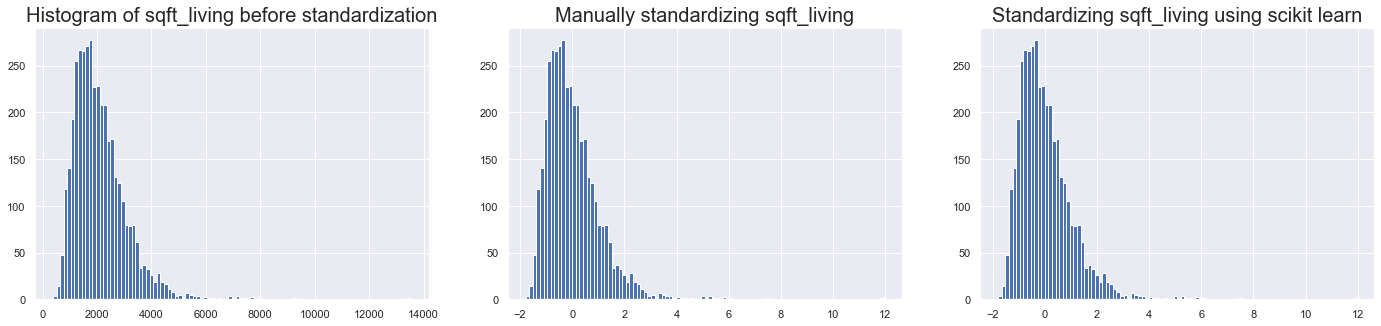

In [13]:
from sklearn.preprocessing import StandardScaler

x = house_df[['sqft_living']]
mu = x.mean()
sigma = x.std()
z = (x-mu)/sigma

#declare sklearn class instance:
scaler = StandardScaler()

# reshaping x to be a n by 1 matrix since that's how scikit learn likes data for standardization
z_sklearn = scaler.fit_transform(x)

# Plotting the histogram of the variable before standardization
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5))
ax = ax.ravel()

ax[0].hist(x, bins=100)
ax[0].set_title('Histogram of sqft_living before standardization', fontsize = 20)

ax[1].hist(z, bins=100)
ax[1].set_title('Manually standardizing sqft_living', fontsize = 20)

ax[2].hist(z_sklearn, bins=100)
ax[2].set_title('Standardizing sqft_living using scikit learn', fontsize = 20);
print(z['sqft_living'].values)
# making things a dataframe to check if they work
pd.DataFrame({'x': x['sqft_living'], 'z_manual': z['sqft_living'], 'z_sklearn': z_sklearn.flatten()}).describe().iloc[[1,2],:]

### Min-Max Scaler (Normalization)

[Here's](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) the scikit-learn implementation of the standard scaler. What is it doing though? 

$$
x_{new} = \frac{x-x_{min}}{x_{max}-x_{min}}
$$

In the above setup: 

- $x_{new}$ is the normalized variable
- $x$ is the variable before normalized
- $x_{max}$ is the max value of the variable before normalization
- $x_{min}$ is the min value of the variable before normalization

Let's see an example of how this works:

,x,x_new_manual,x_new_sklearn
mean,2096.645250,0.130180,0.130180
std,957.785141,0.072802,0.072802
min,384.000000,0.000000,0.000000
max,13540.000000,1.000000,1.000000


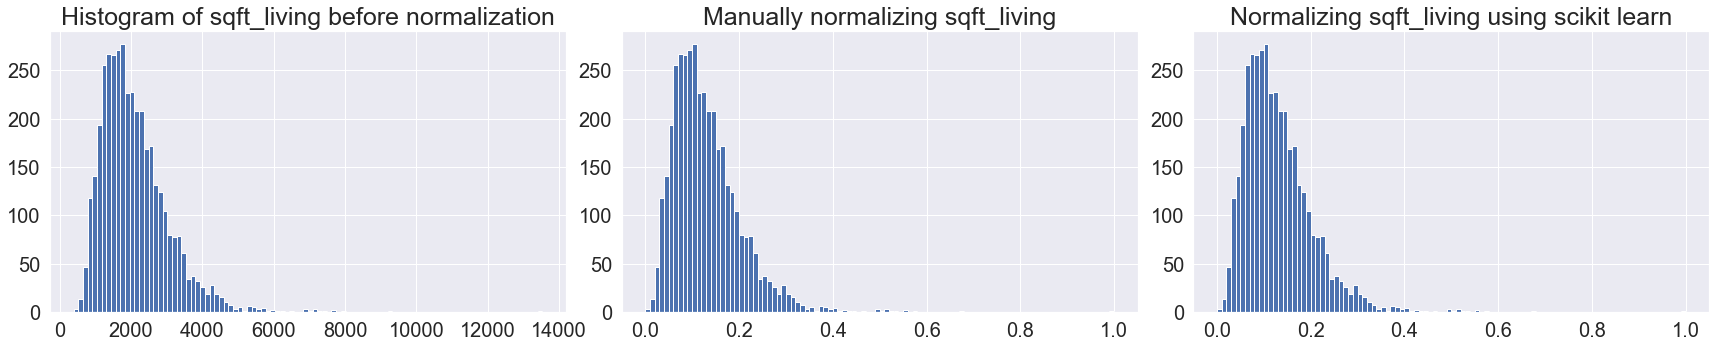

In [14]:
from sklearn.preprocessing import MinMaxScaler

x = house_df['sqft_living']
x_new = (x-x.min())/(x.max()-x.min())

# reshaping x to be a n by 1 matrix since that's how scikit learn likes data for normalization
x_reshaped = np.array(x).reshape(-1,1)
x_new_sklearn = MinMaxScaler().fit_transform(x_reshaped)

# Plotting the histogram of the variable before normalization
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5))
ax = ax.ravel()

titles = ['Histogram of sqft_living before normalization',
         'Manually normalizing sqft_living',
         'Normalizing sqft_living using scikit learn']

for i, design_matrix in enumerate([x, x_new, x_new_sklearn]):
    ax[i].hist(design_matrix, bins=100)
    ax[i].set_title(titles[i], fontsize = 25)
    ax[i].tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()

# making things a dataframe to check if they work
pd.DataFrame({'x': x, 'x_new_manual': x_new, 'x_new_sklearn': x_new_sklearn.flatten()}).describe().iloc[[1,2,3,7],:]

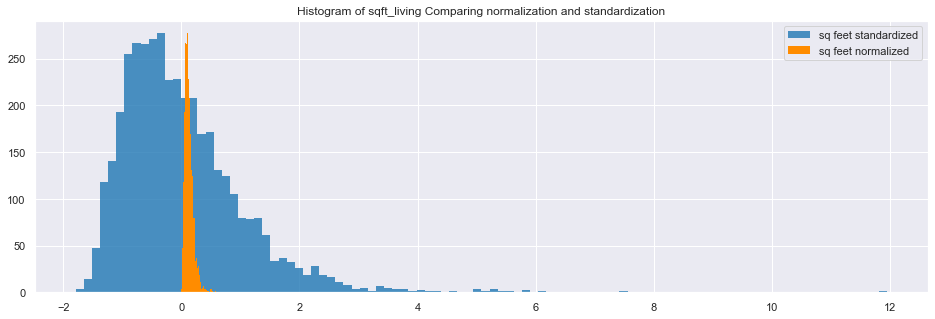

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
ax.hist((x - np.mean(x))/np.std(x), bins=100, alpha = 0.8, label = "sq feet standardized", color = "tab:blue", edgecolor = "none")
ax.hist(x_new, bins=100, label = "sq feet normalized", color = "darkorange", alpha = 1, edgecolor = "none")

ax.set_title('Histogram of sqft_living Comparing normalization and standardization')
plt.legend()
plt.show()

**The million dollar question**

Should I standardize or normalize my data? [This](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc), [this](https://medium.com/@swethalakshmanan14/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff) and [this](https://stackoverflow.com/questions/32108179/linear-regression-normalization-vs-standardization) are useful resources that I highly recommend. But in a nutshell, what they say is the following: 

**Pros of Normalization**

1. Normalization (which makes your data go from 0-1) is widely used in image processing and computer vision, where pixel intensities are non-negative and are typically scaled from a 0-255 scale to a 0-1 range for a lot of different algorithms. 
2. Normalization is also very useful in neural networks (which we will see later in the course) as it leads to the algorithms converging faster. #next semester also we will see
3. Normalization is useful when your data does not have a discernible distribution and you are not making assumptions about your data's distribution.

**Pros of Standardization**

1. Standardization maintains outliers (do you see why?) whereas normalization makes outliers less obvious. In applications where outliers are useful, standardization should be done.
2. Standardization is useful when you assume your data comes from a Gaussian distribution (or something that is approximately Gaussian). 

**Some General Advice**

1. We use the data to calculate the parameters for standardization ($\mu$ and $\sigma$) and for normalization ($x_{min}$ and $x_{max}$). Make sure these parameters are learned on the training set i.e use the training set parameters even when normalizing/standardizing the test set. In sklearn terms, fit your scaler on the training set and use the scaler to transform your test set and validation set (**don't re-fit your scaler on test set data!**).
2. The point of standardization and normalization is to make your variables take on a more manageable scale. You should ideally standardize or normalize all your variables at the same time. 
3. Standardization and normalization is not always needed and is not an automatic thing you have to do on any data science homework!! Do so sparingly and try to justify why this is needed.

**Interpreting Coefficients**

A great quote from [here](https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia)

> [Standardization] makes it so the intercept term is interpreted as the expected value of 𝑌𝑖 when the predictor values are set to their means. Otherwise, the intercept is interpreted as the expected value of 𝑌𝑖 when the predictors are set to 0, which may not be a realistic or interpretable situation (e.g. what if the predictors were height and weight?)

### Standardizing our Design Matrix

In [16]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement',
            'lat', 'long']

X_train = train_df[features]
X_val = val_df[features]
X_test = test_df[features]

#declare specific scaler instance from StandardScaler class. Note that this is not a function.
scaler = StandardScaler()

vars(scaler)

{'with_mean': True, 'with_std': True, 'copy': True}

#### The vars function can be a useful way to check class attributes!

In [17]:
#now fit the scaler
scaler.fit(X_train)
vars(scaler)

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'n_features_in_': 9,
 'n_samples_seen_': 2400,
 'mean_': array([ 3.37375000e+00,  2.11291667e+00,  2.09755292e+03,  1.55479950e+04,
         1.47145833e+00,  1.78859375e+03,  3.08959167e+02,  4.75617963e+01,
        -1.22214560e+02]),
 'var_': array([8.69060938e-01, 6.22874826e-01, 9.41028293e+05, 1.98165019e+09,
        2.80747873e-01, 7.36857945e+05, 2.12346629e+05, 1.90983237e-02,
        1.96806356e-02]),
 'scale_': array([9.32234379e-01, 7.89224193e-01, 9.70066128e+02, 4.45157297e+04,
        5.29856465e-01, 8.58404302e+02, 4.60810839e+02, 1.38196685e-01,
        1.40287689e-01])}

#### Notice how the scaler class instance is storing pesky details —like the mean and standard deviations of the individual features of the data for us.

In [18]:
# This converts our matrices into numpy matrices
X_train_t, X_val_t, X_test_t = [scaler.transform(df) for df in [X_train, X_val, X_test]]

# Making the numpy matrices pandas dataframes
dfs = [ pd.DataFrame(np_array, columns=features) for np_array in [X_train_t, X_val_t, X_test_t]]

X_train, X_val, X_test = dfs

[display(df.describe().iloc[[1,2],:]) for df in dfs];

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long
mean,2.250977e-16,4.503342e-17,1.471971e-16,-2.406640e-17,2.680263e-16,-8.234154e-18,-1.709281e-16,4.928733e-14,4.897231e-14
std,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long
mean,0.018772,0.041444,0.024401,0.016506,0.026737,0.044415,-0.031370,-0.056059,0.016900
std,0.982683,0.997594,0.989079,1.074079,0.991645,0.993807,0.999638,1.008010,1.028649


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long
mean,0.010727,-0.018346,-0.029080,0.052808,0.006684,-0.021866,-0.020484,-0.005631,0.000897
std,0.965422,0.963162,0.946367,1.569619,1.012587,0.955805,0.938793,1.022830,1.028155


In [19]:
# the same code without list comprehension:

# X_train_t = scaler.transform(X_train)
# X_val_t = scaler.transform(X_val)
# X_test_t =  scaler.transform(X_test)

# X_train_df = pd.DataFrame(X_train_t, columns=features)
# X_val_df = pd.DataFrame(X_val_t, columns=features)
# X_test_df = pd.DataFrame(X_test_t, columns=features)

# display(X_train_df.describe())
# display(X_val_df.describe())
# display(X_test_df.describe())

In [20]:
y_train = train_df[['log_price']]
y_val = val_df[['log_price']]
y_test = test_df[['log_price']]

In [21]:
#declare scaler class instance from StandardScaler class
y_scaler = StandardScaler()

#call the .fit_transform method (a method is a class function) to return the transformed data
y_train = scaler.fit_transform(y_train)

#use this to transform the validation and test sets
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

## $PolynomialFeatures$
A common problem that students have when using this class is that they forget that $PolynomialFeatures$ adds a constant column. This can come back to bite us, especially if we aren't aware of it when we use PolynomialFeatures.

#### To simply add a bias column using $PolynomialFeatures$ set the degree equal to one.

In [22]:
from sklearn.preprocessing import PolynomialFeatures

#declare polynomial features object instance
poly_object = PolynomialFeatures(degree = 1)

#now we can call the fit_transform method on the dataframe, := also assigns X_train_df to the reference X.
X_np = poly_object.fit_transform(X := X_train[['sqft_living', 'bedrooms']])

X_pd = pd.DataFrame(X_np, columns = ['const'] + list(X.columns))
X_pd.head()

,const,sqft_living,bedrooms
0,1.0,-0.533523,-0.400918
1,1.0,0.919986,-0.400918
2,1.0,-0.049020,0.671773
3,1.0,-0.121180,-0.400918
4,1.0,-0.327352,-0.400918


If we simply want to add a bias column an easier way is to use use stats_model's `add_constant` function:

In [23]:
import statsmodels.api as sm
X_train_bias = sm.add_constant(X_train)
X_train_bias.head()

,const,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long
0,1.0,-0.400918,-0.459840,-0.533523,-0.184294,-0.889785,-0.243002,-0.670469,-0.261919,-1.179294
1,1.0,-0.400918,1.123994,0.919986,-0.129729,0.997519,1.399581,-0.670469,0.525365,0.289117
2,1.0,0.671773,0.490461,-0.049020,-0.167446,-0.889785,-0.860426,1.499619,0.720739,0.545733
3,1.0,-0.400918,0.490461,-0.121180,-0.035583,-0.889785,0.222979,-0.670469,0.066599,-0.088678
4,1.0,-0.400918,0.490461,-0.327352,-0.187215,-0.889785,-0.452693,0.154165,-1.411729,0.232092


#### $PolynomialFeatures$ is more powerful though, as it can add squared columns to the dataframe.

In [24]:
poly_object = PolynomialFeatures(degree = 2, include_bias = True, interaction_only = False)

X_np = poly_object.fit_transform(X)
pd.DataFrame(X_np).head()

,0,1,2,3,4,5
0,1.0,-0.533523,-0.400918,0.284647,0.213899,0.160736
1,1.0,0.919986,-0.400918,0.846374,-0.368839,0.160736
2,1.0,-0.049020,0.671773,0.002403,-0.032931,0.451279
3,1.0,-0.121180,-0.400918,0.014685,0.048583,0.160736
4,1.0,-0.327352,-0.400918,0.107159,0.131241,0.160736


#### But we lost our column names! No problem. If you saved your polynomial_features $object$ there should be no problem. We can call the $instance's$ `get_feature_names` method to retrieve them:

In [25]:
new_col_names = poly_object.get_feature_names(X.columns)
new_col_names

['1',
 'sqft_living',
 'bedrooms',
 'sqft_living^2',
 'sqft_living bedrooms',
 'bedrooms^2']

In [26]:
X_pd = pd.DataFrame(X_np, columns = new_col_names)
X_pd.head()

,1,sqft_living,bedrooms,sqft_living^2,sqft_living bedrooms,bedrooms^2
0,1.0,-0.533523,-0.400918,0.284647,0.213899,0.160736
1,1.0,0.919986,-0.400918,0.846374,-0.368839,0.160736
2,1.0,-0.049020,0.671773,0.002403,-0.032931,0.451279
3,1.0,-0.121180,-0.400918,0.014685,0.048583,0.160736
4,1.0,-0.327352,-0.400918,0.107159,0.131241,0.160736


If you do have a column of bias in the dataframe you are using to fit, be sure not to fit an intercept! Otherwise sklearn will add a redundant column of ones which can lead to unstable beta0 estimates.

## Bootstrapping

#### What is bootstrapping?

Bootstrapping is a procedure for resampling a dataset with replacement to produce an **empirical distribution** of the value of interest.

#### Key points:

1) Ideally we need to preserve key statistics about the original distribution to come up with a good empirical distribution.

For example, in order to preserve the standard error of the original data we need to sample the same number of points as were in the original data.

$$SE = \frac{\sigma}{\sqrt{n}}$$

2) We must sample with replacement.

#### What is a confidence interval?

A confidence interval is a range of values that is likely to include a parameter of interest with some degree of certainty or "confidence."

#### How do we interpret 95% confidence intervals?

If we were to compute 95% confidence intervals for each of K repeated samples, we would expect 0.95\*K of those confidence intervals to contain the true parameter of interest.



In [27]:
# number of bootstraps

boot_linreg_models = []
boot_betas = []
numboot = 200

col = ["sqft_above"]
X_tr_df = X_train[col]

for i in range(numboot):
    
    #randomly sample indices
    boostrap_i_indices= np.random.choice(X_tr_df.index, replace = True, size = len(X_tr_df.index))
    
    #get bootstrapped dfs
    Xtr_boot = X_tr_df.iloc[boostrap_i_indices,:]
    ytr_boot = y_train[boostrap_i_indices]
    
    bootstrap_lr = LinearRegression(fit_intercept = True).fit(Xtr_boot, ytr_boot)
    
    boot_linreg_models.append(bootstrap_lr)
    coefs = (bootstrap_lr.intercept_[0], bootstrap_lr.coef_[0][0])
    boot_betas.append(coefs)

#linreg_models = np.array(linreg_models)
boot_betas = pd.DataFrame(boot_betas, columns = ["beta0", "beta1"])
boot_betas.head()

,beta0,beta1
0,0.023233,0.601740
1,-0.004621,0.610848
2,0.021559,0.596379
3,-0.027893,0.599161
4,0.009451,0.648927


Lets plot the bootstrap model predictions:

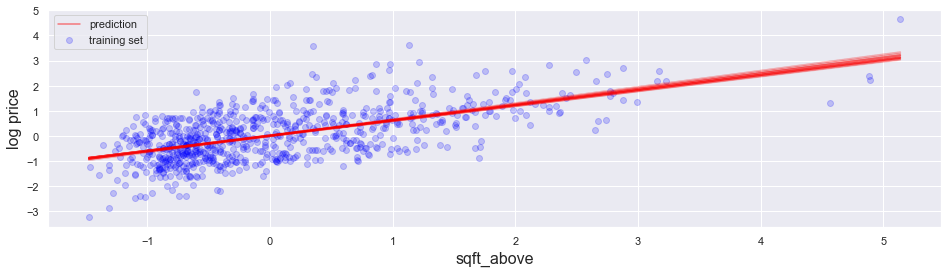

In [28]:
def plot_bootstrap_predictions(boot_linreg_models):
    plt.figure(figsize=(16, 4))
    mses = []
    plt.scatter(X_val[col], y_val, color = "blue", alpha = 0.2, label = "training set")
    for i, model in enumerate(boot_linreg_models[:30]):
        pred = model.predict(X_val[col])
        if i != 0:
            plt.plot(X_val[col], pred, color = "red", alpha = 0.1)
        else:
            label = "prediction"
            plt.plot(X_val[col], pred, color = "red", alpha = 0.5, label = label)

        mses.append(r2_score(y_val, pred))
    plt.xlabel(col[0], fontsize = 16)
    plt.ylabel("log price", fontsize = 16)
    plt.legend();
plot_bootstrap_predictions(boot_linreg_models)

#### Now lets plot the confidence intervals for beta0 and beta1:

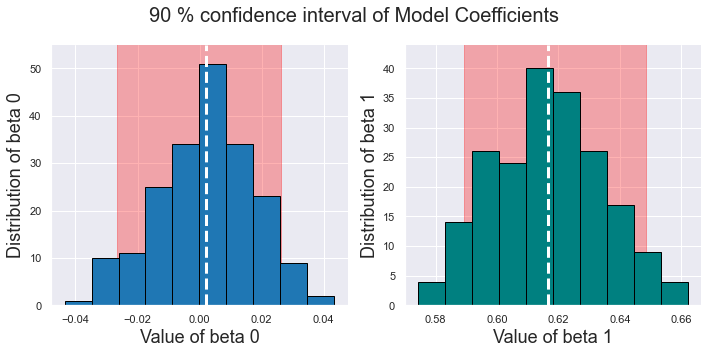

In [29]:
hist_colors = ["tab:blue", "teal"]
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax = ax.ravel()

for i in range(2):
    betavals = boot_betas.iloc[ : , i]
    betavals.values.sort()
    
    x1 = np.percentile(betavals, 5)
    x2 = np.percentile(betavals, 95)
    
    x = np.linspace( x1, x2, 500)
    counts, bins = np.histogram( betavals )
    y = counts.max() 
    plt.sca( ax[i] )
    plt.fill_between(x, y+100, color = 'red',alpha=0.3)
    plt.hist(betavals, 
             bins = bins, 
             color=hist_colors[i],
             alpha=1,
             edgecolor='black', 
             linewidth=1)
    plt.ylim(0,y+ 4)
    plt.ylabel(f'Distribution of beta {i}', fontsize=18)
    plt.xlabel(f'Value of beta {i}', fontsize=18)
    plt.axvline(x = np.mean(betavals), color='w', linewidth = 3, linestyle = "--")

#fig.delaxes(ax[3])
fig.suptitle(f'90 % confidence interval of Model Coefficients', fontsize = 20)
sns.despine()
plt.tight_layout()

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY 1:</strong> The bootstrap loop below is broken. How can we fix it? </div>  


Hint: focus on the line with this pandas dataframe method, use tab inside the parenthesis to see the documentation.


`pd.DataFrame.sample()`

If you have extra time, standardize each Xtr_boot and ytr_boot within the loop.

In [30]:
# number of bootstraps

boot_linreg_models = []
boot_betas = []
numboot = 200

col = ["sqft_above"]
X_tr_df = X_train[col]

for i in range(numboot):
    
    #randomly sample indices
    Xtr_boot = X_tr_df.sample(len(X_tr_df), replace = True) #############################<--- edit this line
    
    #get bootstrapped dfs
    boostrap_i_indices = list(Xtr_boot.index)
    ytr_boot = y_train[boostrap_i_indices]
    
    #as a bonus you can standardize the bootstrapped design matrix and response variable with StandardScaler
    #Xtr_boot = ...
    #ytr_boot = ...
    
    bootstrap_lr = LinearRegression(fit_intercept = True).fit(Xtr_boot, ytr_boot)
    
    boot_linreg_models.append(bootstrap_lr)
    coefs = (bootstrap_lr.intercept_[0], bootstrap_lr.coef_[0][0])
    boot_betas.append(coefs)

#linreg_models = np.array(linreg_models)
boot_betas = pd.DataFrame(boot_betas, columns = ["beta0", "beta1"])
boot_betas.head()

,beta0,beta1
0,0.017948,0.606647
1,-0.020604,0.599112
2,-0.031599,0.622405
3,0.001592,0.631495
4,-0.034460,0.598515


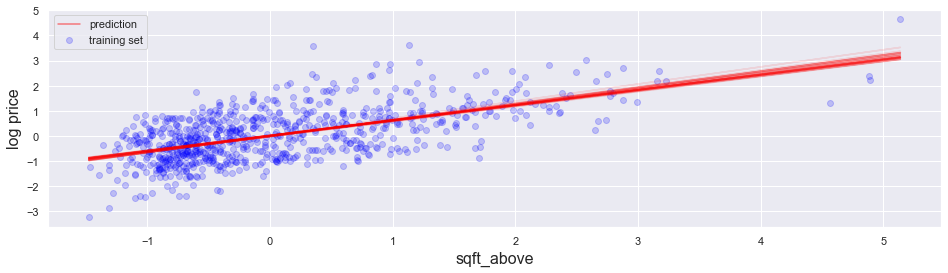

In [31]:
plot_bootstrap_predictions(boot_linreg_models)

In [32]:
#%run make_plots/make_plots.py

# Regularization

## What is Regularization and why should I care?

When we have a lot of predictors, we need to worry about overfitting. Let's check this out:

In [33]:
#from statsmodels.regression.linear_model import OLS

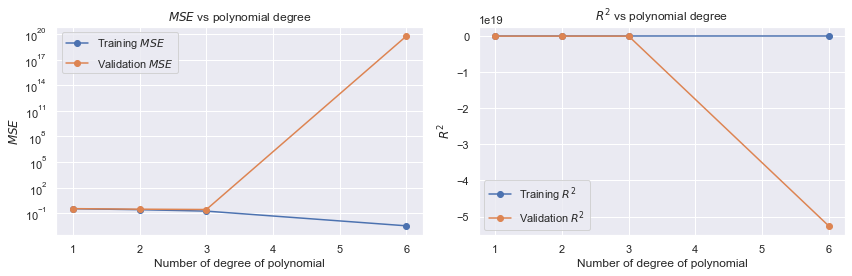

In [34]:
N = 6
degrees = [1,2,3,N]
r2_train = []
r2_val = []
mse_train = []
mse_val = []

for i, d in enumerate(degrees):
    poly = PolynomialFeatures(d, include_bias = True)
    X_tr = poly.fit_transform(X_train)
    Xval = poly.fit_transform(X_val)
    
    model_N = LinearRegression(fit_intercept = False).fit(X_tr, y_train)
    y_pred_tra = model_N.predict(X_tr)
    y_pred_val = model_N.predict(Xval)
    
    r2_train.append(r2_score(y_train, y_pred_tra))
    r2_val.append(r2_score(y_val, y_pred_val))
    
    mse_train.append(mean_squared_error(y_train, y_pred_tra))
    mse_val.append(mean_squared_error(y_val, y_pred_val))

best_least_squares_r2 = np.max(r2_val)

fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.sca(ax[0])
plt.plot(degrees, mse_train, 'o-', label=r'Training $MSE$')
plt.plot(degrees, mse_val, 'o-', label=r'Validation $MSE$')
plt.xlabel('Number of degree of polynomial')
plt.ylabel(r'$MSE$')
plt.title(r'$MSE$ vs polynomial degree')
plt.yscale('log')
plt.legend();

plt.sca(ax[1])
plt.plot(degrees, r2_train, 'o-', label=r'Training $R^2$')
plt.plot(degrees, r2_val, 'o-', label=r'Validation $R^2$')
plt.xlabel('Number of degree of polynomial')
plt.ylabel(r'$R^2$')
plt.title(r'$R^2$ vs polynomial degree')
plt.legend()
plt.tight_layout()

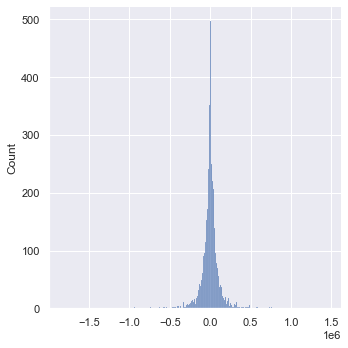

In [35]:
sns.displot(model_N.coef_.reshape(-1,))

We notice a big difference between training and validation R^2 scores: seems like we are overfitting. **Introducing: regularization.**

## What about Multicollinearity?

There's seemingly a lot of multicollinearity in the data. Here is a standard collinearity warning issued by statsmodels:

<img src="fig/warning.png" width=400>

What is [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)? Why do we have it in our dataset? Why is this a problem? 

Does regularization help solve the issue of multicollinearity? 

## What does Regularization help with?

We have some pretty large and extreme coefficient values in our most recent models. These coefficient values also have very high variance. We can also clearly see some overfitting to the training set. In order to reduce the coefficients of our parameters, we can introduce a penalty term that penalizes some of these extreme coefficient values. Specifically, regularization helps us: 

1. Avoid overfitting. Reduce features that have weak predictive power.
2. Discourage the use of a model that is too complex

<img src="./fig/overfit.png" width="600">

### Big Idea: Reduce Variance by Increasing Bias

Image Source: [here](https://www.cse.wustl.edu/~m.neumann/sp2016/cse517/lecturenotes/lecturenote12.html)

<img src="fig/bias_variance.png" width="600">

## Ridge Regression

Ridge Regression is one such form of regularization. In practice, the ridge estimator reduces the complexity of the model by shrinking the coefficients, but it doesn’t nullify them. We control the amount of regularization using a parameter $\lambda$. **NOTE**: sklearn's [ridge regression package](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) represents this $\lambda$ using a parameter alpha. In Ridge Regression, the penalty term is proportional to the L2-norm of the coefficients. 



<img src="fig/ridge.png" width="400">





## Lasso Regression

Lasso Regression is another form of regularization. Again, we control the amount of regularization using a parameter $\lambda$. **NOTE**: sklearn's [lasso regression package](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) represents this $\lambda$ using a parameter alpha. In Lasso Regression, the penalty term is proportional to the L1-norm of the coefficients. 



<img src="fig/lasso.png" width="400">





### Some Differences between Ridge and Lasso Regression

1. Since Lasso regression tend to produce zero estimates for a number of model parameters - we say that Lasso solutions are **sparse** - we consider to be a method for variable selection.
2. In Ridge Regression, the penalty term is proportional to the L2-norm of the coefficients whereas in Lasso Regression, the penalty term is proportional to the L1-norm of the coefficients.
3. Ridge Regression has a closed form solution! Lasso Regression does not. We often have to solve this iteratively. In the sklearn package for Lasso regression, there is a parameter called `max_iter` that determines how many iterations we perform. 

<img src="fig/3d_ridge_lasso.png" width="800">
<img src="fig/Lasso_formula.png" width="400">
<img src="fig/Ridge_formula.png" width="400">

<img src="fig/ridge_geom_breakdown.png" width="800">
<img src="fig/ridge_geometric.png" width="400">





<img src="fig/lasso_geometric.png" width="400">



### Why Standardizing Variables was not a waste of time

Lasso regression puts constraints on the size of the coefficients associated to each variable. However, this value will depend on the magnitude of each variable. It is therefore necessary to standardize the variables. 

## Let's use Ridge and Lasso to regularize our degree N polynomial

**Exercise**: Play around with different values of alpha. Notice the new $R^2$ value and also the range of values that the predictors take in the plot.

In [36]:
N = 4
poly = PolynomialFeatures(N)
X_train_df_N = poly.fit_transform(X_train)
X_val_df_N = poly.fit_transform(X_val)

n_scaler = StandardScaler()
X_train_df_N = n_scaler.fit_transform(X_train_df_N)
X_val_df_N = n_scaler.transform(X_val_df_N )

R squared score for our original OLS model: -5.255758396239907e+19
R squared score for Ridge with alpha=0.01: -42.29042625387663


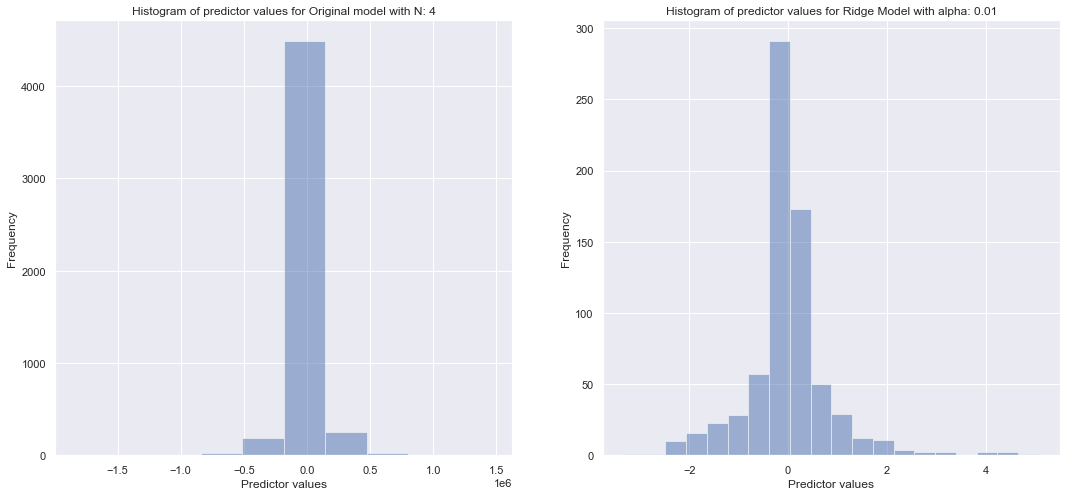

In [37]:
from sklearn.linear_model import Ridge

# some values you can try out: 0.01, 0.1, 0.5, 1, 5, 10, 20, 40, 100, 200, 500, 1000, 10000
alpha =0.01

ridge_model = Ridge(alpha=alpha).fit(X_train_df_N, y_train)

print('R squared score for our original OLS model: {}'.format(r2_val[-1]))
print('R squared score for Ridge with alpha={}: {}'.format(alpha, ridge_model.score(X_val_df_N,y_val)))

fig, ax = plt.subplots(figsize=(18,8), ncols=2)
ax = ax.ravel()
ax[0].hist(model_N.coef_.flatten(), bins=10, alpha=0.5)
ax[0].set_title('Histogram of predictor values for Original model with N: {}'.format(N))
ax[0].set_xlabel('Predictor values')
ax[0].set_ylabel('Frequency')

ax[1].hist(ridge_model.coef_.flatten(), bins=20, alpha=0.5)
ax[1].set_title('Histogram of predictor values for Ridge Model with alpha: {}'.format(alpha))
ax[1].set_xlabel('Predictor values')
ax[1].set_ylabel('Frequency');

R squared score for our original model: -5.255758396239907e+19
R squared score for Lasso with alpha=0.01: 0.7927159432914455


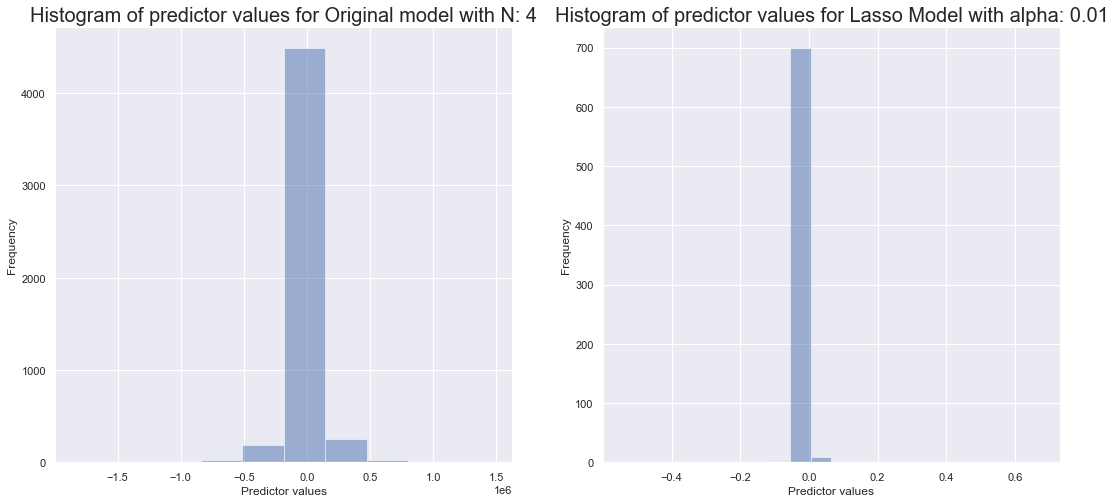

In [38]:
from sklearn.linear_model import Lasso

# some values you can try out: 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20
#alpha = 0.0001
lasso_model = Lasso(alpha=alpha, max_iter = 1000).fit(X_train_df_N, y_train)

print('R squared score for our original model: {}'.format(r2_val[-1]))
print('R squared score for Lasso with alpha={}: {}'.format(alpha, lasso_model.score(X_val_df_N,y_val)))

fig, ax = plt.subplots(figsize=(18,8), ncols=2)
ax = ax.ravel()
ax[0].hist(model_N.coef_.flatten(), bins=10, alpha=0.5)
ax[0].set_title('Histogram of predictor values for Original model with N: {}'.format(N), fontsize = 20)
ax[0].set_xlabel('Predictor values')
ax[0].set_ylabel('Frequency')

ax[1].hist(lasso_model.coef_.flatten(), bins=20, alpha=0.5)
ax[1].set_title('Histogram of predictor values for Lasso Model with alpha: {}'.format(alpha), fontsize = 20)
ax[1].set_xlabel('Predictor values')
ax[1].set_ylabel('Frequency');

## Model Selection and Cross-Validation

Here's our current setup so far: 

<img src="fig/cross_val.png" width="400">


So we try out 10,000 different models on our validation set and pick the one that's the best? No! **Since we could also be overfitting the validation set!** 

One solution to the problems raised by using a single validation set is to evaluate each model on multiple validation sets and average the validation performance. This is the essence of cross-validation!

<img src="fig/cross_val.png" width="700">

Image source: [here](https://medium.com/@sebastiannorena/some-model-tuning-methods-bfef3e6544f0)

Let's give this a try using [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) and [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html):

In [39]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

alphas = (0.001, 0.01, 0.1, 10, 100, 1000, 10000)

# Let us do k-fold cross validation 
k = 4
fitted_ridge = RidgeCV(alphas=alphas, cv = k).fit(X_train_df_N, y_train)
fitted_lasso = LassoCV(alphas=alphas, cv = k).fit(X_train_df_N, y_train)

print('R^2 score for our original least squares model: {}\n'.format(r2_val[-1]))

ridge_a = fitted_ridge.alpha_
print('Best alpha for ridge: {}'.format(ridge_a))
print('R^2 score for Ridge with alpha={}: {}\n'.format(ridge_a, fitted_ridge.score(X_val_df_N,y_val)))

lasso_a = fitted_lasso.alpha_
print('Best alpha for lasso: {}'.format(lasso_a))
print('R squared score for Lasso with alpha={}: {}'.format(lasso_a, fitted_lasso.score(X_val_df_N,y_val)))

R^2 score for our original least squares model: -5.255758396239907e+19

Best alpha for ridge: 1000.0
R^2 score for Ridge with alpha=1000.0: 0.6983132045949638

Best alpha for lasso: 0.01
R squared score for Lasso with alpha=0.01: 0.7927159432914455


We can also look at the coefficients of our CV models.

**Final Step:** report the score on the test set for the model you have chosen to be the best.

## Sklearn's <a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html' > cross_validate</a> function:

You may find this useful on the homework. Say you have fit a model on the training set. You will be asked to perform cross validation and score models on the homework based on this function. Below is an example of how to do this. You will also want to choose an appropriate <a href = 'https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter'> scoring method</a>. Please read the documentation for this function. I've included some psuedo-code below:

loss_score = cross_validate(model, X, y, cv=3, scoring = 'r2')

In [40]:
X_train_df_N.shape

(2400, 715)

Best R^2 Score: 0.4550841102353611: 


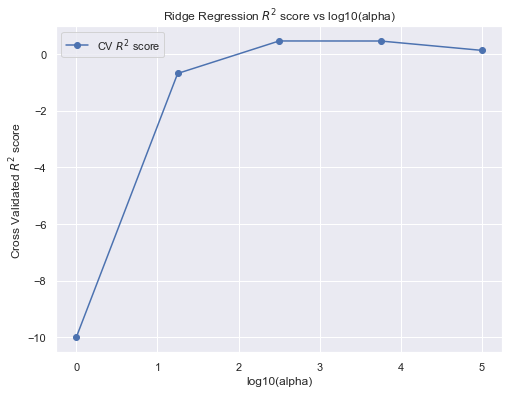

In [41]:
from sklearn.model_selection import cross_validate

#scale the design matrix
X_train_df_N = StandardScaler().fit_transform(X_train_df_N)
y_train= StandardScaler().fit_transform(y_train)

#alpha values to optimize
alphas = [10**i for i in np.linspace(0, 5, 5)]
sklearn_models = []

#fit our various models
for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha)
    sklearn_models.append(model)

#get the cross validation scores
for i, model in enumerate(sklearn_models):
    #if i == 0 initialize our lists
    if not i:
        r2_train = []
        r2_val = []

    r2_cv_scores = cross_validate(model, X_train_df_N, y_train, cv=4, scoring = 'r2')
    r2_avg_score = np.mean(r2_cv_scores["test_score"])
    r2_train.append(r2_avg_score)
    
#plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.log10(alphas), r2_train, 'o-', label=r'CV $R^2$ score')
ax.set_xlabel('log10(alpha)')
ax.set_ylabel(r'Cross Validated $R^2$ score')
ax.set_title(r'Ridge Regression $R^2$ score vs log10(alpha)')
ax.legend()

print("Best R^2 Score: {}: ".format(np.max(r2_train)))


<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY 2:</strong> Fixing Ridge and Lasso CV </div>  


1) Finish the `preprocess` helper function <br>
2) Finish the `fit_ridge_and_lasso_cv` helper function <br>
3) Play with the arguments of the `preprocess` and `fit_ridge_and_lasso_cv` helper functions to try and improve the performance on the test set. <br>
4) Talk with your break out room members about the questions posed

In [42]:
%run make_plots/make_plots.py

In [43]:
df1 = pd.read_csv("./data/team_exercise2.csv")

### 1) Fill out the standardization lines in this helper function

In [44]:
# def preprocess(df, standardize = False):
#     """Splits the data into training and validation sets.
#     arguments:
#         df: the dataframe of training and test data you want to split.
#         standardize: if True returns standardized data.
#     """
#     #split the data
#     train, test = train_test_split(df, train_size=0.8, random_state = 42)
    
#     #sort the data
#     train = train.sort_values(by = ["x1"])
#     test = test.sort_values(by = ["x1"])

#     train.describe()

#     X_train, y_train = train[["x1"]], train["y"]
#     X_test, y_test = test[["x1"]], test["y"]

#     X_train_N = add_higher_order_polynomial_terms(X_train, N=15)
#     X_test_N = add_higher_order_polynomial_terms(X_test, N=15)
    
#     if standardize:
#         scaler = ...
#         X_train_N = ...
#         X_test_N = ...
    
#     #"X_val" : X_val_N, "y_val" : y_val,
#     datasets = {"X_train": X_train_N, "y_train":  y_train,  "X_test" : X_test_N, "y_test": y_test}
#     return(datasets)


### 2) Fill out the missing lines in this helper function in order to perform cross validated ridge and lasso regression on the synthetic dataset.

In [45]:
# def fit_ridge_and_lasso_cv(X_train, y_train,  X_test, y_test,  k = None, alphas = [10**7],
#                            best_OLS_r2 = best_least_squares_r2): #X_val, y_val,
#     """ takes in train and validation test sets and reports the best selected model using ridge and lasso regression.
#     Arguments:
#         X_train: the train design matrix
#         y_train: the reponse variable for the training set
#         X_val: the validation design matrix
#         y_train: the reponse variable for the validation set
#         k: the number of k-fold cross validation sections to be fed to Ridge and Lasso Regularization.
#     """
#     #declare the ridge and lasso cv objects: (change the arguments to include alphas and k).
#     # Let us do k-fold cross validation.
#     ridgecv_instance = RidgeCV(...)
#     lassocv_instance = LassoCV(...)
    
#     # now fit the cv_object instances. They will return fitted models:
#     ridge_instance = ...
#     lasso_instance = ...
    
#     print('R^2 score for our original OLS model: {}\n'.format(best_OLS_r2))

#     ridge_a = ridge_instance.alpha_
#     ridge_score = ridge_instance.score(X_test, y_test)
#     print('Best alpha for ridge: {}'.format(ridge_a))
#     print('R^2 score for Ridge with alpha={}: {}\n'.format(ridge_a, ridge_score))

#     lasso_a = lasso_instance.alpha_
#     lasso_score = lasso_instance.score(X_test, y_test)
#     print('Best alpha for lasso: {}'.format(lasso_a))
    
#     print('R^2 score for Lasso with alpha={}: {}'.format(lasso_a, lasso_score))
    
#     r2_df = pd.DataFrame({"OLS": best_OLS_r2, "Lasso" : lasso_score, "Ridge" : ridge_score}, index = [0])
#     r2_df = r2_df.melt()
#     r2_df.columns = ["model", "r2_Score"]
#     plt.title("Validation set")
#     sns.barplot(x = "model", y = "r2_Score", data = r2_df)
#     plt.show()

If you are on your local machine you may view the solutions by running the following magic command. We will release a notebook with the solutions later on ed as well.

In [46]:
# %load "./solutions/solution1.py"
def preprocess(df, standardize = False):
    """Splits the data into training and validation sets.
    arguments:
        df: the dataframe of training and test data you want to split.
        standardize: if True returns standardized data.
    """
    #split the data
    train, test = train_test_split(df, train_size=0.8, random_state = 42)
    
    #sort the data
    train = train.sort_values(by = ["x1"])
    test = test.sort_values(by = ["x1"])

    train.describe()

    X_train, y_train = train[["x1"]], train["y"]
    X_test, y_test = test[["x1"]], test["y"]

    X_train_N = add_higher_order_polynomial_terms(X_train, N=15)
    X_test_N = add_higher_order_polynomial_terms(X_test, N=15)
    
    if standardize:
        scaler = StandardScaler().fit(X_train_N)
        X_train_N = scaler.transform(X_train_N)
        X_test_N = scaler.transform(X_test_N)
    
    #"X_val" : X_val_N, "y_val" : y_val,
    datasets = {"X_train": X_train_N, "y_train":  y_train,  "X_test" : X_test_N, "y_test": y_test}
    return(datasets)

def fit_ridge_and_lasso_cv(X_train, y_train,  X_test, y_test,  
                           k = None, alphas = [10**9], best_OLS_r2 = best_least_squares_r2 ): #X_val, y_val,
    """ takes in train and validation test sets and reports the best selected model using ridge and lasso regression.
    Arguments:
        X_train: the train design matrix
        y_train: the reponse variable for the training set
        X_val: the validation design matrix
        y_train: the reponse variable for the validation set
        k: the number of k-fold cross validation sections to be fed to Ridge and Lasso Regularization.
    """

    # Let us do k-fold cross validation 
    fitted_ridge = RidgeCV(alphas=alphas, cv = k).fit(X_train, y_train)
    fitted_lasso = LassoCV(alphas=alphas, cv = k).fit(X_train, y_train)
    
    print('R^2 score for our original OLS model: {}\n'.format(best_OLS_r2))

    ridge_a = fitted_ridge.alpha_
    ridge_score = fitted_ridge.score(X_test, y_test)
    print('Best alpha for ridge: {}'.format(ridge_a))
    print('R^2 score for Ridge with alpha={}: {}\n'.format(ridge_a, ridge_score))

    lasso_a = fitted_lasso.alpha_
    lasso_score = fitted_lasso.score(X_test, y_test)
    print('Best alpha for lasso: {}'.format(lasso_a))
    
    print('R^2 score for Lasso with alpha={}: {}'.format(lasso_a, lasso_score))
    
    r2_df = pd.DataFrame({"OLS": best_OLS_r2, "Lasso" : lasso_score, "Ridge" : ridge_score}, index = [0])
    r2_df = r2_df.melt()
    r2_df.columns = ["model", "r2_Score"]
    plt.title("Validation set")
    sns.barplot(x = "model", y = "r2_Score", data = r2_df)
    
    plt.show()

** 1) Run the cell below to see the performance of the OLS, Lasso, and Ridge models on the test set**

R^2 score for our original OLS model: 0.7425155478002274

Best alpha for ridge: 100000.0
R^2 score for Ridge with alpha=100000.0: 0.8332636706203881

Best alpha for lasso: 1000000000.0
R^2 score for Lasso with alpha=1000000000.0: -0.0023143115940502668


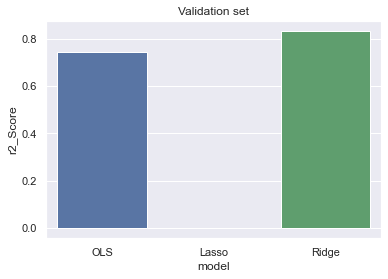

In [47]:
datasets = preprocess(df1)
#Here we input arguments to a function from a dictionary using the ** syntax option.
# X_train, y_train, X_val, y_val,

fit_ridge_and_lasso_cv(**datasets, alphas = [10**float(i) for i in (np.array(range(20)) - 10)])

**2) How can we improve our results using ridge and lasso (ie boost the $R^2$ score?). Try to play with the arguments of the helper functions to increase the $R^2$ scores and discuss with your group why this works. Don't split the data or try to write your own functions here.**

In [48]:
# #TODO (hint copy and paste the previous cell)
# datasets = preprocess(df1, standardize = True)
# #Here we input arguments to a function from a dictionary using the ** syntax option.
# # X_train, y_train, X_val, y_val,

# fit_ridge_and_lasso_cv(**datasets)

R^2 score for our original OLS model: 0.7425155478002274

Best alpha for ridge: 1.0
R^2 score for Ridge with alpha=1.0: 0.8328111456797884

Best alpha for lasso: 0.1
R^2 score for Lasso with alpha=0.1: 0.8228188396902885


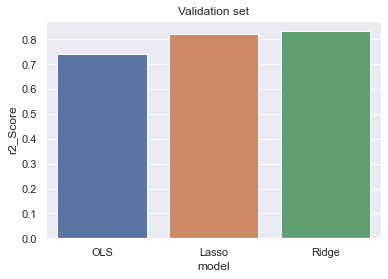

In [49]:
# %load "./solutions/solution2.py"
datasets = preprocess(df1, standardize = True)
#Here we input arguments to a function from a dictionary using the ** syntax option.
# X_train, y_train, X_val, y_val,

fit_ridge_and_lasso_cv(**datasets, k = 4, alphas = [10**i for i in range(-10, 5)])

***3) Would we in effect be cheating if we optimize our model over k at this stage? Why?***

----------------
### End of Standard Section
---------------